<a href="https://colab.research.google.com/github/yoyoyo-yo/DeepLearningMugenKnock/blob/master/Scripts_Generative/pytorch/WGANGP_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WGAN-GP

元論文 : Improved Training of Wasserstein GANs https://arxiv.org/abs/1704.00028 (2017)

### 論文のサマリ 

WGANのパラメータのクリッピングは最適化を難しくするというのがWGAN-GPの導入背景。
Critic(DiscriminatorをWGANの論文ではCriticと呼ぶ)にBatch Normalizationが入っているとパラメータのクリッピング問題は弱めることができるけど、深いCriticでは収束しにくいらしい。

Criticのパラメータを[-c, c]にクリッピングするが、cの値を注意深く選ばないと勾配消失か勾配爆発になってしまう。しかし、WGANでWasserstain距離を用いた画像でLossを作るために1Lipschits制約を実現するために、このクリッピングが必要だった。

なので、**WGAN-GPでは勾配を1に近づける正則化項（=GP : Gradient Penalty) を導入することで、クリッピングを行わずに1Lipschits制約を実現する。**

ただし、BatchNormalizationはバッチで正規化するけど、GPは入力毎に行うので、相性が悪い。CriticではBatchNormalizationの代わりにLayerNormalizationを入れた。(これで結果も良くなった)

以上がWGAN-GPの論文での主張

DCGAN, LSGAN, WGAN, WGAN-GPを比較するために、GeneratorとDiscriminatorにいろんな条件をつけて LSUNデータセットで試した。その結果がFigure.2。WGAN-GPがずば抜けていい画像を作っている。しかもRes101をGとDに使ってもモード崩壊に陥らないという。

### アルゴリズム

WGAN-GPのアルゴリズムは、イテレーション毎に以下のDiscriminatorとGeneratorの学習を交互に行っていく。
- 最適化 : Adam (LearningRate: 0.0001, β1=0, β2=0.9)
- λ = 10

アルゴリズム

#### Discriminatorの学習(以下をcriticの回数だけ繰り返す）

1. ノイズzをサンプリングし、 $G_z = G(z)$ を求める
2. $\epsilon \in [0, 1]$ をランダムに選び、Realデータ$X$ と　$G_z$ の重み付き平均 $\hat{x} = \epsilon X + (1 - \epsilon) G_z$ を計算する
3. Loss $L^i = D(G_z) - D(X) + \lambda (\| \nabla_{\hat{x}} D(\hat{x}) \|_2 - 1)^2$　を計算し、SGD

#### Generatorの学習

1. ノイズzをサンプリングして、 Loss $L = \frac{1}{|Minibatch|} \sum_{i} - D(G(z))$ を計算し、SGD

GeneratorとDiscriminatorの構造は次の通り。WGAN-GPではResBlock構造を導入して、Deepな構造にしている。

#### Generator

ResNetの活性化関数はReLU

<img src='https://github.com/yoyoyo-yo/DeepLearningMugenKnock/blob/master/Scripts_Generative/assets/WGAN-gp_D.png' width=600>

#### Discriminator

ResNetの活性化関数はLeakyReLU(0.2)

<img src='https://github.com/yoyoyo-yo/DeepLearningMugenKnock/blob/master/Scripts_Generative/assets/WGAN-gp_D.png' width=600>

それぞれにおいてResBlockは以下の構造となる

#### ResBlock

<img src='../assets/WGAN-gp_ResBlock.png' width=300>

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install numpy matplotlib opencv-python torch torchvision torchsummary pandas easydict

## Import and Config

In [50]:
import torch
import torch.nn.functional as F
import torchvision
import numpy as np
from collections import OrderedDict
from easydict import EasyDict
import argparse
import os
import matplotlib.pyplot as plt
import pandas as pd
from torchsummary import summary
from pprint import pprint

import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/pytorch/')
from _main_base_generative import *

#---
# config
#---
cfg = EasyDict()

# class
cfg.CLASS_LABEL = ['akahara', 'madara'] # list, dict('label' : '[B, G, R]')
cfg.CLASS_NUM = len(cfg.CLASS_LABEL)

# model
cfg.INPUT_Z_DIM = 128
cfg.INPUT_MODE = None

cfg.OUTPUT_HEIGHT = 64
cfg.OUTPUT_WIDTH = 64
cfg.OUTPUT_CHANNEL = 3
cfg.OUTPUT_MODE = 'RGB'  # RGB, GRAY, EDGE, CLASS_LABEL
cfg.OUTPUT_CMAP = None # pyplot cmap

cfg.G_DIM = 32
cfg.D_DIM = 32
cfg.RES_BLOCK_DIM = 64

cfg.CHANNEL_AXIS = 1 # 1 ... [mb, c, h, w], 3 ... [mb, h, w, c]

cfg.GPU = True
cfg.DEVICE_TYPE = 'cuda' if cfg.GPU and torch.cuda.is_available() else 'cpu'
cfg.DEVICE = torch.device(cfg.DEVICE_TYPE)

# train
cfg.TRAIN = EasyDict()
cfg.TRAIN.DISPAY_ITERATION_INTERVAL = 50

cfg.PREFIX = 'WGAN-GP'
cfg.TRAIN.MODEL_G_SAVE_PATH = 'models/' + cfg.PREFIX + '_G_{}.pt'
cfg.TRAIN.MODEL_D_SAVE_PATH = 'models/' + cfg.PREFIX + '_D_{}.pt'
cfg.TRAIN.MODEL_SAVE_INTERVAL = 200
cfg.TRAIN.ITERATION = 10_000
cfg.TRAIN.MINIBATCH = 32
cfg.TRAIN.OPTIMIZER_G = torch.optim.Adam
cfg.TRAIN.LEARNING_PARAMS_G = {'lr' : 0.0001, 'betas' : (0., 0.9)}
cfg.TRAIN.OPTIMIZER_D = torch.optim.Adam
cfg.TRAIN.LEARNING_PARAMS_D = {'lr' : 0.0001, 'betas' : (0., 0.9)}
cfg.TRAIN.LOSS_FUNCTION = None

cfg.TRAIN.DATA_PATH = '/content/drive/My Drive/Colab Notebooks/Dataset/train/images/'
cfg.TRAIN.DATA_HORIZONTAL_FLIP = True # data augmentation : holizontal flip
cfg.TRAIN.DATA_VERTICAL_FLIP = True # data augmentation : vertical flip
cfg.TRAIN.DATA_ROTATION = 1 # data augmentation : rotation False, or integer

cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE = True
cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL = 500
cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'
cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH = 'result/' + cfg.PREFIX + '_loss.txt'

#---
# WGAN  config
#---
cfg.TRAIN.WGAN_CRITIC_N = 5
cfg.TRAIN.WGAN_GP_LAMBDA = 10

# test
cfg.TEST = EasyDict()
cfg.TEST.MODEL_G_PATH = cfg.TRAIN.MODEL_G_SAVE_PATH.format('final')
cfg.TEST.DATA_PATH = '/content/drive/My Drive/Colab Notebooks/Dataset/test/images/'
cfg.TEST.MINIBATCH = 10
cfg.TEST.ITERATION = 2
cfg.TEST.RESULT_SAVE = False
cfg.TEST.RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'

# random seed
torch.manual_seed(0)


# make model save directory
def make_dir(path):
    if '/' in path:
        model_save_dir = '/'.join(path.split('/')[:-1])
        os.makedirs(model_save_dir, exist_ok=True)

make_dir(cfg.TRAIN.MODEL_G_SAVE_PATH)
make_dir(cfg.TRAIN.MODEL_D_SAVE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH)

pprint(cfg)

{'CHANNEL_AXIS': 1,
 'CLASS_LABEL': ['akahara', 'madara'],
 'CLASS_NUM': 2,
 'DEVICE': device(type='cuda'),
 'DEVICE_TYPE': 'cuda',
 'D_DIM': 32,
 'GPU': True,
 'G_DIM': 32,
 'INPUT_MODE': None,
 'INPUT_Z_DIM': 128,
 'OUTPUT_CHANNEL': 3,
 'OUTPUT_CMAP': None,
 'OUTPUT_HEIGHT': 64,
 'OUTPUT_MODE': 'RGB',
 'OUTPUT_WIDTH': 64,
 'PREFIX': 'WGAN-GP',
 'RES_BLOCK_DIM': 64,
 'TEST': {'DATA_PATH': '/content/drive/My Drive/Colab '
                       'Notebooks/Dataset/test/images/',
          'ITERATION': 2,
          'MINIBATCH': 10,
          'MODEL_G_PATH': 'models/WGAN-GP_G_final.pt',
          'RESULT_IMAGE_PATH': 'result/WGAN-GP_result_{}.jpg',
          'RESULT_SAVE': False},
 'TRAIN': {'DATA_HORIZONTAL_FLIP': True,
           'DATA_PATH': '/content/drive/My Drive/Colab '
                        'Notebooks/Dataset/train/images/',
           'DATA_ROTATION': 1,
           'DATA_VERTICAL_FLIP': True,
           'DISPAY_ITERATION_INTERVAL': 50,
           'ITERATION': 10000,
           

## Define Model

In [0]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)

class Reshape(torch.nn.Module):
    def __init__(self, c, h, w):
        super(Reshape, self).__init__()
        self.c = c
        self.h = h
        self.w = w
    
    def forward(self, x):
        return x.view(x.size()[0], self.c, self.h, self.w)

    
# ResNet block
class ResBlock(torch.nn.Module):
    def __init__(self, dim_first=None, dim=cfg.RES_BLOCK_DIM, activation_fn=torch.nn.ReLU(), batch_norm=False, name=''):
        super(ResBlock, self).__init__()

        if dim_first is None:
            dim_first = dim
        #else:
        if batch_norm:
            self.skip_conv = torch.nn.Sequential(OrderedDict({
                name + '_skip_bn' : torch.nn.BatchNorm2d(dim_first),
                name + '_skip_activation' : activation_fn,
                name + '_skip_conv' : torch.nn.Conv2d(dim_first, dim, kernel_size=3, padding=1, stride=1)
            }))
        else:
            self.skip_conv = torch.nn.Sequential(OrderedDict({
                name + '_skip_activation' : activation_fn,
                name + '_skip_conv' : torch.nn.Conv2d(dim_first, dim, kernel_size=3, padding=1, stride=1)
            }))
        
        if batch_norm:
            self.block = torch.nn.Sequential(OrderedDict({
                name + '_layer_1_bn' : torch.nn.BatchNorm2d(dim_first),
                name + '_layer_1_activation' : activation_fn,
                name + '_layer_1_conv' : torch.nn.Conv2d(dim_first, dim, kernel_size=3, padding=1, stride=1),
                name + '_layer_2_bn' : torch.nn.BatchNorm2d(dim),
                name + '_layer_2_activation' : activation_fn,
                name + '_layer_2_conv' : torch.nn.Conv2d(dim, dim, kernel_size=3, padding=1, stride=1)
            }))
        else:
            self.block = torch.nn.Sequential(OrderedDict({
                name + '_layer_1_activation' : activation_fn,
                name + '_layer_1_conv' : torch.nn.Conv2d(dim_first, dim, kernel_size=3, padding=1, stride=1),
                name + '_layer_2_activation' : activation_fn,
                name + '_layer_2_conv' : torch.nn.Conv2d(dim, dim, kernel_size=3, padding=1, stride=1)
            }))


    def forward(self, x):
        res_x = self.block(x)

        if hasattr(self, 'skip_conv'):
            x = self.skip_conv(x)
        
        return F.relu(res_x + x)

    
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.module = torch.nn.Sequential(OrderedDict({
            #'G_layer_1' : torch.nn.Linear(cfg.INPUT_Z_DIM, cfg.G_DIM * (cfg.OUTPUT_HEIGHT // 8) * (cfg.OUTPUT_WIDTH // 8)),
            #'G_layer_1_reshape' : Reshape(cfg.G_DIM, cfg.OUTPUT_HEIGHT // 8, cfg.OUTPUT_HEIGHT // 8),
            'G_layer_1' : torch.nn.ConvTranspose2d(cfg.INPUT_Z_DIM, cfg.G_DIM, 
                                                     kernel_size=[cfg.OUTPUT_HEIGHT // 8, cfg.OUTPUT_WIDTH // 8], stride=1, padding=0),
            'G_layer_1_bn' : torch.nn.BatchNorm2d(cfg.G_DIM),
            'G_layer_1_activation' : torch.nn.ReLU(),     
            
            'G_layer_2_resBlock' : ResBlock(dim_first=cfg.G_DIM, activation_fn=torch.nn.ReLU(), batch_norm=True, name='G_resBlock_1'),
            'G_layer_2_upsampling' : torch.nn.UpsamplingBilinear2d(scale_factor=2),
            
            'G_layer_3_resBlock' : ResBlock(activation_fn=torch.nn.ReLU(), batch_norm=True, name='G_resBlock_2'),
            'G_layer_3_upsampling' : torch.nn.UpsamplingBilinear2d(scale_factor=2),
            
            'G_layer_4_resBlock' : ResBlock(activation_fn=torch.nn.ReLU(), batch_norm=True, name='G_resBlock_3'),
            'G_layer_4_upsampling' : torch.nn.UpsamplingBilinear2d(scale_factor=2),
        
            'G_layer_out' : torch.nn.Conv2d(cfg.RES_BLOCK_DIM, cfg.OUTPUT_CHANNEL, kernel_size=3, stride=1, padding=1),
            'G_layer_out_activation' : torch.nn.Tanh(),
        }))
        
    def forward(self, x):
        return self.module(x)


class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()    
        self.module = torch.nn.Sequential(OrderedDict({
            'D_layer_1_resBlock' : ResBlock(dim_first=cfg.OUTPUT_CHANNEL, dim=cfg.D_DIM, 
                                            activation_fn=torch.nn.LeakyReLU(0.2), batch_norm=False, name='D_resBlock_1'),
            'D_layer_1_pool' : torch.nn.AvgPool2d(2, stride=2),

            'D_layer_2_resBlock' : ResBlock(dim_first=cfg.D_DIM, activation_fn=torch.nn.LeakyReLU(0.2), batch_norm=False, name='D_resBlock_2'),
            'D_layer_2_pool' : torch.nn.AvgPool2d(2, stride=2),

            'D_layer_3_resBlock' : ResBlock(activation_fn=torch.nn.LeakyReLU(0.2), batch_norm=False, name='D_resBlock_3'),

            'D_layer_4_resBlock' : ResBlock(activation_fn=torch.nn.LeakyReLU(0.2), batch_norm=False, name='D_resBlock_4'),
            'D_layer_4_activation' : torch.nn.ReLU(),

            'D_layer_out' : torch.nn.Conv2d(cfg.RES_BLOCK_DIM, 1, kernel_size=[cfg.OUTPUT_HEIGHT // 4, cfg.OUTPUT_WIDTH // 4], 
                                            stride=1, padding=0),
            'D_layer_out_flatten' : Flatten()
            #'D_layer_5_pool' : torch.nn.AdaptiveAvgPool2d((1, 1)),
            #'D_layer_5_flatten' : Flatten(),
            #'D_layer_out' : torch.nn.Linear(cfg.D_DIM, 1),
        }))

    def forward(self, x):
        return self.module(x)

    
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('bn') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0)

## Utility

In [0]:
def result_show(G, z, path=None, save=False, show=False,  figsize=(12, 4), cmap=None):
    if (save or show) is False:
        print('argument save >> {} and show >> {}, so skip')
        return

    Gz = G(z)
    Gz = Gz.detach().cpu().numpy()

    Gz = (Gz * 127.5 + 127.5).astype(np.uint8)
    Gz = Gz.reshape([-1, cfg.OUTPUT_CHANNEL, cfg.OUTPUT_HEIGHT, cfg.OUTPUT_WIDTH])
    Gz = Gz.transpose(0, 2, 3, 1)

    plt.figure(figsize=figsize)
    
    for i in range(cfg.TEST.MINIBATCH):
        _G = Gz[i]
        plt.subplot(1, cfg.TEST.MINIBATCH, i + 1)
        plt.imshow(_G, cmap=cmap)
        plt.axis('off')

    if path is not None:
        plt.savefig(path)
        print('result was saved to >> {}'.format(path))

    if show:
        plt.show()

## Train

100%|██████████| 16/16 [00:00<00:00, 1741.14it/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1             [-1, 32, 8, 8]         262,176
       BatchNorm2d-2             [-1, 32, 8, 8]              64
              ReLU-3             [-1, 32, 8, 8]               0
       BatchNorm2d-4             [-1, 32, 8, 8]              64
              ReLU-5             [-1, 32, 8, 8]               0
              ReLU-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 64, 8, 8]          18,496
       BatchNorm2d-8             [-1, 64, 8, 8]             128
              ReLU-9             [-1, 64, 8, 8]               0
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11             [-1, 64, 8, 8]          36,928
      BatchNorm2d-12             [-1, 32, 8, 8]              64
             ReLU-13             [-1, 32, 8, 8]               0
             ReLU-14             [-1, 3

Iter:50, LossG (fake:-72178.5469), LossD:101696.7734 (real:-150501.2188, fake:-94244.7969), WDistance:-56256.4219, GP:45440.3516
Iter:100, LossG (fake:-54410.1016), LossD:78957.5391 (real:-96770.4531, fake:-39537.8320), WDistance:-57232.6211, GP:21724.9199
Iter:150, LossG (fake:41411.5742), LossD:93113.7344 (real:-18012.0117, fake:41521.0234), WDistance:-59533.0352, GP:33580.6992
Iter:200, LossG (fake:101119.5156), LossD:84078.2188 (real:-2349.8066, fake:55158.1289), WDistance:-57507.9375, GP:26570.2832
save G >> models/WGAN-GP_G_iter200.pt, D >> models/WGAN-GP_D_iter200.pt
Iter:250, LossG (fake:-176265.7188), LossD:142341.5469 (real:-288426.6250, fake:-186654.7656), WDistance:-101771.8594, GP:40569.6914
Iter:300, LossG (fake:187959.0312), LossD:93076.6875 (real:104141.9609, fake:167991.3438), WDistance:-63849.3828, GP:29227.3008
Iter:350, LossG (fake:114169.1953), LossD:64675.9375 (real:81402.4609, fake:127027.8281), WDistance:-45625.3672, GP:19050.5684
Iter:400, LossG (fake:-13649.02

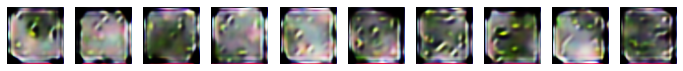

Iter:550, LossG (fake:-79834.3438), LossD:64814.7500 (real:-151018.1562, fake:-110809.9062), WDistance:-40208.2500, GP:24606.5020
Iter:600, LossG (fake:-25221.0117), LossD:39817.6602 (real:-54509.4883, fake:-26941.9844), WDistance:-27567.5039, GP:12250.1553
save G >> models/WGAN-GP_G_iter600.pt, D >> models/WGAN-GP_D_iter600.pt
Iter:650, LossG (fake:-85879.1641), LossD:53421.0781 (real:-89756.6250, fake:-51818.3984), WDistance:-37938.2266, GP:15482.8516
Iter:700, LossG (fake:36944.4844), LossD:55048.1172 (real:27000.3906, fake:64521.5430), WDistance:-37521.1523, GP:17526.9648
Iter:750, LossG (fake:30177.8984), LossD:36221.0898 (real:-12761.4668, fake:10345.3574), WDistance:-23106.8242, GP:13114.2656
Iter:800, LossG (fake:-42593.2344), LossD:36846.5508 (real:-39407.5469, fake:-13520.3477), WDistance:-25887.1992, GP:10959.3506
save G >> models/WGAN-GP_G_iter800.pt, D >> models/WGAN-GP_D_iter800.pt
Iter:850, LossG (fake:-5646.2759), LossD:41799.3750 (real:-55442.2891, fake:-28429.2148), W

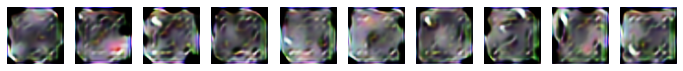

Iter:1050, LossG (fake:215934.7031), LossD:69752.7188 (real:143540.5938, fake:192316.0469), WDistance:-48775.4531, GP:20977.2656
Iter:1100, LossG (fake:90620.2812), LossD:40154.4062 (real:36153.7969, fake:66274.8438), WDistance:-30121.0469, GP:10033.3594
Iter:1150, LossG (fake:-132799.2812), LossD:47332.3594 (real:-176816.2812, fake:-144217.7656), WDistance:-32598.5156, GP:14733.8457
Iter:1200, LossG (fake:12039.0088), LossD:42213.6172 (real:-16754.8184, fake:12259.0137), WDistance:-29013.8320, GP:13199.7871
save G >> models/WGAN-GP_G_iter1200.pt, D >> models/WGAN-GP_D_iter1200.pt
Iter:1250, LossG (fake:-160976.8438), LossD:56673.6406 (real:-184076.5469, fake:-148186.6250), WDistance:-35889.9219, GP:20783.7188
Iter:1300, LossG (fake:-86102.0625), LossD:40602.9141 (real:-86002.0469, fake:-56644.2734), WDistance:-29357.7734, GP:11245.1426
Iter:1350, LossG (fake:-110850.9219), LossD:35732.7578 (real:-134118.6250, fake:-107984.8438), WDistance:-26133.7812, GP:9598.9756
Iter:1400, LossG (fa

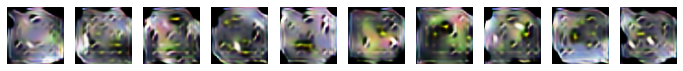

Iter:1550, LossG (fake:18443.3242), LossD:54169.2578 (real:-15288.2783, fake:23144.7188), WDistance:-38432.9961, GP:15736.2598
Iter:1600, LossG (fake:-120677.8281), LossD:28273.4199 (real:-126924.0312, fake:-108167.1250), WDistance:-18756.9062, GP:9516.5137
save G >> models/WGAN-GP_G_iter1600.pt, D >> models/WGAN-GP_D_iter1600.pt
Iter:1650, LossG (fake:-52784.2695), LossD:28174.0957 (real:-75189.0625, fake:-56513.3008), WDistance:-18675.7617, GP:9498.3340
Iter:1700, LossG (fake:51949.4375), LossD:32811.1875 (real:15982.5986, fake:39080.0859), WDistance:-23097.4883, GP:9713.7002
Iter:1750, LossG (fake:-34648.6562), LossD:23897.5859 (real:-45137.8203, fake:-29076.8926), WDistance:-16060.9277, GP:7836.6572
Iter:1800, LossG (fake:-4538.0840), LossD:31005.8145 (real:-37178.0117, fake:-16028.6240), WDistance:-21149.3867, GP:9856.4277
save G >> models/WGAN-GP_G_iter1800.pt, D >> models/WGAN-GP_D_iter1800.pt
Iter:1850, LossG (fake:61485.3242), LossD:17912.5977 (real:61930.1875, fake:75551.7500

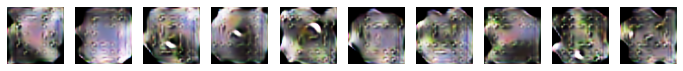

Iter:2050, LossG (fake:22329.7207), LossD:62090.0586 (real:14499.8086, fake:57119.0469), WDistance:-42619.2383, GP:19470.8203
Iter:2100, LossG (fake:-35665.8359), LossD:22466.1992 (real:-46103.6484, fake:-30954.7266), WDistance:-15148.9219, GP:7317.2773
Iter:2150, LossG (fake:84559.7812), LossD:23517.6289 (real:78164.4844, fake:93302.5156), WDistance:-15138.0312, GP:8379.5967
Iter:2200, LossG (fake:-86233.2656), LossD:20778.7891 (real:-102166.0547, fake:-86882.9922), WDistance:-15283.0625, GP:5495.7275
save G >> models/WGAN-GP_G_iter2200.pt, D >> models/WGAN-GP_D_iter2200.pt
Iter:2250, LossG (fake:102305.9297), LossD:15498.9434 (real:106391.7031, fake:118481.1328), WDistance:-12089.4297, GP:3409.5132
Iter:2300, LossG (fake:36292.3281), LossD:26937.2969 (real:18455.8242, fake:34734.3750), WDistance:-16278.5508, GP:10658.7451
Iter:2350, LossG (fake:69520.3516), LossD:17297.2539 (real:63851.2266, fake:76999.2500), WDistance:-13148.0234, GP:4149.2305
Iter:2400, LossG (fake:3653.7830), Loss

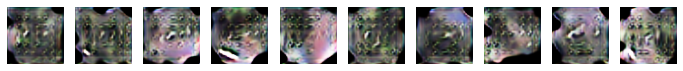

Iter:2550, LossG (fake:208281.6875), LossD:40775.0547 (real:164100.0312, fake:193462.3906), WDistance:-29362.3594, GP:11412.6953
Iter:2600, LossG (fake:66203.0781), LossD:17244.2383 (real:56798.9219, fake:68278.2578), WDistance:-11479.3359, GP:5764.9033
save G >> models/WGAN-GP_G_iter2600.pt, D >> models/WGAN-GP_D_iter2600.pt
Iter:2650, LossG (fake:-12782.7793), LossD:20926.1992 (real:-28720.0195, fake:-15096.3242), WDistance:-13623.6953, GP:7302.5039
Iter:2700, LossG (fake:45665.1094), LossD:22894.2168 (real:43455.6250, fake:59847.2266), WDistance:-16391.6016, GP:6502.6147
Iter:2750, LossG (fake:57776.4023), LossD:14260.1377 (real:42742.6250, fake:53019.8750), WDistance:-10277.2500, GP:3982.8877
Iter:2800, LossG (fake:65207.6328), LossD:24539.6309 (real:53568.1797, fake:69721.5469), WDistance:-16153.3672, GP:8386.2637
save G >> models/WGAN-GP_G_iter2800.pt, D >> models/WGAN-GP_D_iter2800.pt
Iter:2850, LossG (fake:27658.5273), LossD:28272.0000 (real:15830.7422, fake:38146.4531), WDista

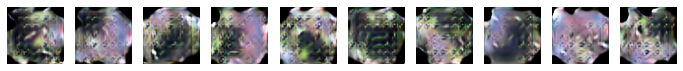

Iter:3050, LossG (fake:158931.5469), LossD:14808.8760 (real:147050.0312, fake:159126.0312), WDistance:-12076.0000, GP:2732.8760
Iter:3100, LossG (fake:127015.4766), LossD:15943.3906 (real:100641.1484, fake:110995.2031), WDistance:-10354.0547, GP:5589.3354
Iter:3150, LossG (fake:208988.7344), LossD:12477.3926 (real:209516.8750, fake:217371.0312), WDistance:-7854.1562, GP:4623.2368
Iter:3200, LossG (fake:219244.7500), LossD:13254.5889 (real:200960.3438, fake:210232.1250), WDistance:-9271.7812, GP:3982.8076
save G >> models/WGAN-GP_G_iter3200.pt, D >> models/WGAN-GP_D_iter3200.pt
Iter:3250, LossG (fake:190707.0312), LossD:20765.5273 (real:139976.6875, fake:155639.5625), WDistance:-15662.8750, GP:5102.6533
Iter:3300, LossG (fake:47607.3359), LossD:34288.0781 (real:17886.9414, fake:39813.6328), WDistance:-21926.6914, GP:12361.3867
Iter:3350, LossG (fake:131138.2500), LossD:14221.3486 (real:118671.3906, fake:128205.1875), WDistance:-9533.7969, GP:4687.5518
Iter:3400, LossG (fake:107269.2656)

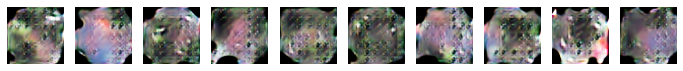

Iter:3550, LossG (fake:148842.4219), LossD:18171.9082 (real:140770.8438, fake:153656.6719), WDistance:-12885.8281, GP:5286.0801
Iter:3600, LossG (fake:68505.2109), LossD:26761.8281 (real:52915.0938, fake:73344.2812), WDistance:-20429.1875, GP:6332.6406
save G >> models/WGAN-GP_G_iter3600.pt, D >> models/WGAN-GP_D_iter3600.pt
Iter:3650, LossG (fake:117035.5703), LossD:11193.8564 (real:99090.5000, fake:107146.3984), WDistance:-8055.8984, GP:3137.9580
Iter:3700, LossG (fake:133399.5312), LossD:14658.8057 (real:120617.2031, fake:131542.4688), WDistance:-10925.2656, GP:3733.5398
Iter:3750, LossG (fake:111794.8516), LossD:15865.3262 (real:100175.6719, fake:111164.5469), WDistance:-10988.8750, GP:4876.4512
Iter:3800, LossG (fake:79698.8359), LossD:12781.5244 (real:67184.2266, fake:77034.6328), WDistance:-9850.4062, GP:2931.1182
save G >> models/WGAN-GP_G_iter3800.pt, D >> models/WGAN-GP_D_iter3800.pt
Iter:3850, LossG (fake:94386.8125), LossD:13995.1133 (real:89558.8047, fake:98740.6875), WDis

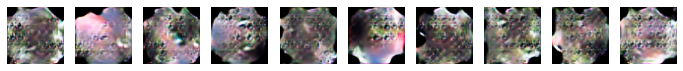

Iter:4050, LossG (fake:81311.1016), LossD:13572.8828 (real:84265.1641, fake:94612.3828), WDistance:-10347.2188, GP:3225.6646
Iter:4100, LossG (fake:210375.1875), LossD:21964.6953 (real:179247.7969, fake:196549.0781), WDistance:-17301.2812, GP:4663.4131
Iter:4150, LossG (fake:44832.5938), LossD:33644.7344 (real:29604.1992, fake:56773.2461), WDistance:-27169.0469, GP:6475.6880
Iter:4200, LossG (fake:172375.4531), LossD:9472.6172 (real:168434.4219, fake:175094.6562), WDistance:-6660.2344, GP:2812.3823
save G >> models/WGAN-GP_G_iter4200.pt, D >> models/WGAN-GP_D_iter4200.pt
Iter:4250, LossG (fake:211822.7188), LossD:11334.6543 (real:207108.0781, fake:215032.7188), WDistance:-7924.6406, GP:3410.0142
Iter:4300, LossG (fake:206724.7188), LossD:13198.2305 (real:188359.7500, fake:198319.0312), WDistance:-9959.2812, GP:3238.9487
Iter:4350, LossG (fake:149456.1719), LossD:15961.4648 (real:128641.5938, fake:140635.0625), WDistance:-11993.4688, GP:3967.9961
Iter:4400, LossG (fake:171729.2188), Los

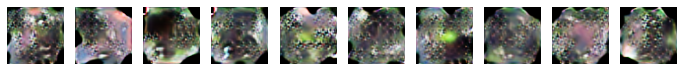

Iter:4550, LossG (fake:165708.8750), LossD:8055.0166 (real:146590.0000, fake:152910.2031), WDistance:-6320.2031, GP:1734.8132
Iter:4600, LossG (fake:204567.5000), LossD:18779.7031 (real:178754.9688, fake:192861.9844), WDistance:-14107.0156, GP:4672.6880
save G >> models/WGAN-GP_G_iter4600.pt, D >> models/WGAN-GP_D_iter4600.pt
Iter:4650, LossG (fake:191638.0156), LossD:10900.0186 (real:184243.3125, fake:191864.6875), WDistance:-7621.3750, GP:3278.6436
Iter:4700, LossG (fake:200486.9688), LossD:10507.8359 (real:192444.8906, fake:199818.9844), WDistance:-7374.0938, GP:3133.7424
Iter:4750, LossG (fake:231572.4062), LossD:12654.2773 (real:223169.4062, fake:231997.8750), WDistance:-8828.4688, GP:3825.8081
Iter:4800, LossG (fake:222954.1562), LossD:11408.1465 (real:217386.8906, fake:224686.6875), WDistance:-7299.7969, GP:4108.3491
save G >> models/WGAN-GP_G_iter4800.pt, D >> models/WGAN-GP_D_iter4800.pt
Iter:4850, LossG (fake:147070.0938), LossD:11894.5830 (real:131297.6250, fake:139243.3594)

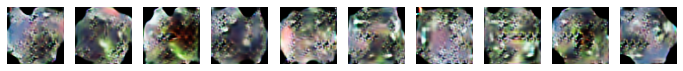

Iter:5050, LossG (fake:84922.5859), LossD:21778.5938 (real:67223.1250, fake:84310.7656), WDistance:-17087.6406, GP:4690.9541
Iter:5100, LossG (fake:98870.6953), LossD:12707.5430 (real:93933.9219, fake:101769.4609), WDistance:-7835.5391, GP:4872.0044
Iter:5150, LossG (fake:150895.1875), LossD:12579.2373 (real:127409.3359, fake:137432.5469), WDistance:-10023.2109, GP:2556.0264
Iter:5200, LossG (fake:90373.7266), LossD:9349.7598 (real:95263.1172, fake:101592.0547), WDistance:-6328.9375, GP:3020.8218
save G >> models/WGAN-GP_G_iter5200.pt, D >> models/WGAN-GP_D_iter5200.pt
Iter:5250, LossG (fake:226695.6562), LossD:24507.9766 (real:211072.3125, fake:227542.5312), WDistance:-16470.2188, GP:8037.7588
Iter:5300, LossG (fake:163682.0781), LossD:12206.7207 (real:150667.2188, fake:159065.9844), WDistance:-8398.7656, GP:3807.9546
Iter:5350, LossG (fake:193181.1094), LossD:19028.4883 (real:167656.6250, fake:182660.3750), WDistance:-15003.7500, GP:4024.7383
Iter:5400, LossG (fake:249855.0469), Loss

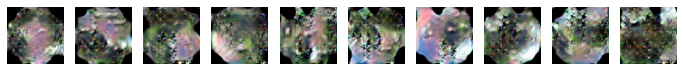

Iter:5550, LossG (fake:209928.9688), LossD:14404.9473 (real:200446.8594, fake:210832.3438), WDistance:-10385.4844, GP:4019.4624
Iter:5600, LossG (fake:289182.4375), LossD:15523.6699 (real:273137.8125, fake:283737.3125), WDistance:-10599.5000, GP:4924.1694
save G >> models/WGAN-GP_G_iter5600.pt, D >> models/WGAN-GP_D_iter5600.pt
Iter:5650, LossG (fake:228710.0938), LossD:11769.1758 (real:195805.7656, fake:203733.4062), WDistance:-7927.6406, GP:3841.5356
Iter:5700, LossG (fake:177921.6875), LossD:13362.6660 (real:169125.6562, fake:178467.7812), WDistance:-9342.1250, GP:4020.5415
Iter:5750, LossG (fake:119094.1406), LossD:22464.4336 (real:93507.0312, fake:109810.4609), WDistance:-16303.4297, GP:6161.0049
Iter:5800, LossG (fake:116132.3594), LossD:14921.9385 (real:110046.6406, fake:119315.9531), WDistance:-9269.3125, GP:5652.6260
save G >> models/WGAN-GP_G_iter5800.pt, D >> models/WGAN-GP_D_iter5800.pt
Iter:5850, LossG (fake:117353.4219), LossD:11194.1455 (real:107995.1719, fake:115117.031

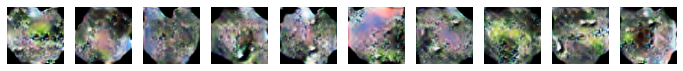

Iter:6050, LossG (fake:207807.0312), LossD:13997.2051 (real:179860.4062, fake:190377.9062), WDistance:-10517.5000, GP:3479.7051
Iter:6100, LossG (fake:146693.2812), LossD:9510.4424 (real:139576.3906, fake:146153.9531), WDistance:-6577.5625, GP:2932.8799
Iter:6150, LossG (fake:228866.0938), LossD:15322.9727 (real:206374.6562, fake:217317.1250), WDistance:-10942.4688, GP:4380.5039
Iter:6200, LossG (fake:71802.9688), LossD:16636.2598 (real:78237.2031, fake:88808.1250), WDistance:-10570.9219, GP:6065.3374
save G >> models/WGAN-GP_G_iter6200.pt, D >> models/WGAN-GP_D_iter6200.pt
Iter:6250, LossG (fake:48201.6445), LossD:10074.2461 (real:40280.6250, fake:46808.3750), WDistance:-6527.7500, GP:3546.4963
Iter:6300, LossG (fake:82767.5156), LossD:11066.6641 (real:64760.8125, fake:72474.1250), WDistance:-7713.3125, GP:3353.3516
Iter:6350, LossG (fake:4020.1997), LossD:12029.3955 (real:-9153.4805, fake:-1597.0554), WDistance:-7556.4248, GP:4472.9707
Iter:6400, LossG (fake:111076.1719), LossD:12287

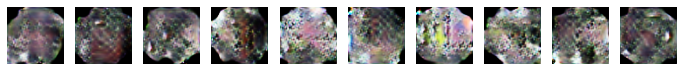

Iter:6550, LossG (fake:69223.9219), LossD:9282.0586 (real:53822.2578, fake:60512.5352), WDistance:-6690.2773, GP:2591.7808
Iter:6600, LossG (fake:64303.8945), LossD:12426.1650 (real:58593.4531, fake:66804.2734), WDistance:-8210.8203, GP:4215.3447
save G >> models/WGAN-GP_G_iter6600.pt, D >> models/WGAN-GP_D_iter6600.pt
Iter:6650, LossG (fake:89231.9141), LossD:10606.2578 (real:73526.8203, fake:80437.0156), WDistance:-6910.1953, GP:3696.0630
Iter:6700, LossG (fake:-77880.1094), LossD:9723.0713 (real:-105597.3594, fake:-98596.6719), WDistance:-7000.6875, GP:2722.3840
Iter:6750, LossG (fake:89198.0312), LossD:8499.2256 (real:88897.7969, fake:94871.5625), WDistance:-5973.7656, GP:2525.4602
Iter:6800, LossG (fake:108603.2188), LossD:10855.8984 (real:103810.2891, fake:111664.3125), WDistance:-7854.0234, GP:3001.8748
save G >> models/WGAN-GP_G_iter6800.pt, D >> models/WGAN-GP_D_iter6800.pt
Iter:6850, LossG (fake:32348.6992), LossD:9143.3037 (real:6339.1514, fake:11826.5078), WDistance:-5487.3

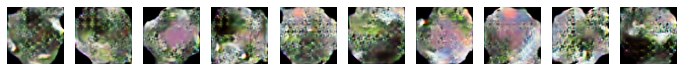

Iter:7050, LossG (fake:17386.4238), LossD:13683.8262 (real:-471.8333, fake:8865.8457), WDistance:-9337.6787, GP:4346.1475
Iter:7100, LossG (fake:196003.7500), LossD:7456.8647 (real:178717.0312, fake:184629.4375), WDistance:-5912.4062, GP:1544.4586
Iter:7150, LossG (fake:-62200.3906), LossD:11076.6055 (real:-83483.5547, fake:-75050.3281), WDistance:-8433.2266, GP:2643.3784
Iter:7200, LossG (fake:193388.6094), LossD:15671.5391 (real:145227.3125, fake:154820.1562), WDistance:-9592.8438, GP:6078.6958
save G >> models/WGAN-GP_G_iter7200.pt, D >> models/WGAN-GP_D_iter7200.pt
Iter:7250, LossG (fake:-51068.2812), LossD:8722.9023 (real:-73150.4688, fake:-67571.5781), WDistance:-5578.8906, GP:3144.0112
Iter:7300, LossG (fake:-309361.1250), LossD:6874.3286 (real:-295351.4688, fake:-291404.9062), WDistance:-3946.5625, GP:2927.7661
Iter:7350, LossG (fake:-153026.5938), LossD:9290.6543 (real:-162010.1562, fake:-155075.4531), WDistance:-6934.7031, GP:2355.9507
Iter:7400, LossG (fake:46239.1562), Loss

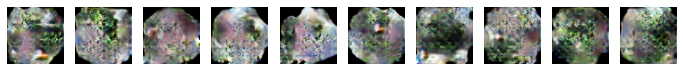

Iter:7550, LossG (fake:-122445.3125), LossD:12279.4531 (real:-107677.3906, fake:-99043.3594), WDistance:-8634.0312, GP:3645.4219
Iter:7600, LossG (fake:-32265.3418), LossD:10575.4727 (real:-63032.6992, fake:-55489.8750), WDistance:-7542.8242, GP:3032.6484
save G >> models/WGAN-GP_G_iter7600.pt, D >> models/WGAN-GP_D_iter7600.pt
Iter:7650, LossG (fake:-52148.0312), LossD:8631.9355 (real:-77743.8750, fake:-71887.6484), WDistance:-5856.2266, GP:2775.7092
Iter:7700, LossG (fake:-312208.1562), LossD:10911.3164 (real:-262073.7969, fake:-253000.6250), WDistance:-9073.1719, GP:1838.1444
Iter:7750, LossG (fake:-160220.6406), LossD:10729.4385 (real:-200458.6406, fake:-193743.5625), WDistance:-6715.0781, GP:4014.3601
Iter:7800, LossG (fake:-429760.6875), LossD:18933.9180 (real:-380760.6875, fake:-367017.3125), WDistance:-13743.3750, GP:5190.5430
save G >> models/WGAN-GP_G_iter7800.pt, D >> models/WGAN-GP_D_iter7800.pt
Iter:7850, LossG (fake:-101540.9062), LossD:10657.1660 (real:-104349.8047, fake

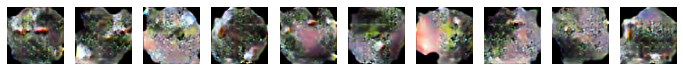

Iter:8050, LossG (fake:-148688.5312), LossD:11831.1406 (real:-172230.7500, fake:-164198.5312), WDistance:-8032.2188, GP:3798.9219
Iter:8100, LossG (fake:-4820.8218), LossD:14308.6592 (real:-52812.6328, fake:-41919.4609), WDistance:-10893.1719, GP:3415.4871
Iter:8150, LossG (fake:-44795.8008), LossD:13428.6201 (real:-75308.5938, fake:-65397.2266), WDistance:-9911.3672, GP:3517.2532
Iter:8200, LossG (fake:-84956.8047), LossD:24482.4141 (real:-141057.2031, fake:-123190.2500), WDistance:-17866.9531, GP:6615.4600
save G >> models/WGAN-GP_G_iter8200.pt, D >> models/WGAN-GP_D_iter8200.pt
Iter:8250, LossG (fake:-102141.2969), LossD:10068.0068 (real:-111487.7109, fake:-103966.9219), WDistance:-7520.7891, GP:2547.2178
Iter:8300, LossG (fake:-299356.6250), LossD:16766.3164 (real:-327402.0938, fake:-315698.2500), WDistance:-11703.8438, GP:5062.4717
Iter:8350, LossG (fake:-276872.0000), LossD:10747.9258 (real:-230582.1562, fake:-222731.1250), WDistance:-7851.0312, GP:2896.8940
Iter:8400, LossG (fak

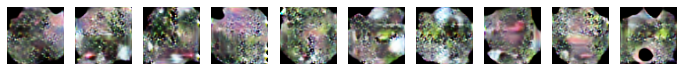

Iter:8550, LossG (fake:-100159.0391), LossD:13231.6289 (real:-87961.4531, fake:-78730.1719), WDistance:-9231.2812, GP:4000.3479
Iter:8600, LossG (fake:77608.9531), LossD:9484.5195 (real:47595.0312, fake:53485.0391), WDistance:-5890.0078, GP:3594.5112
save G >> models/WGAN-GP_G_iter8600.pt, D >> models/WGAN-GP_D_iter8600.pt
Iter:8650, LossG (fake:-12915.1299), LossD:12561.2939 (real:-21303.3906, fake:-12359.6875), WDistance:-8943.7031, GP:3617.5908
Iter:8700, LossG (fake:-151530.8906), LossD:7271.6494 (real:-162377.0938, fake:-157465.5781), WDistance:-4911.5156, GP:2360.1340
Iter:8750, LossG (fake:-263924.4688), LossD:14570.1719 (real:-225483.9375, fake:-216318.4688), WDistance:-9165.4688, GP:5404.7031
Iter:8800, LossG (fake:81041.4219), LossD:15036.2803 (real:41221.1797, fake:51567.8047), WDistance:-10346.6250, GP:4689.6553
save G >> models/WGAN-GP_G_iter8800.pt, D >> models/WGAN-GP_D_iter8800.pt
Iter:8850, LossG (fake:-189008.5156), LossD:10027.8613 (real:-193894.1406, fake:-186508.50

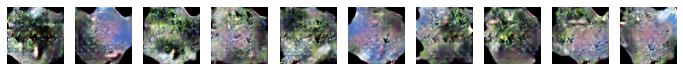

Iter:9050, LossG (fake:-324000.5625), LossD:19256.6797 (real:-293403.5625, fake:-278677.0000), WDistance:-14726.5625, GP:4530.1167
Iter:9100, LossG (fake:-319921.0312), LossD:19445.7266 (real:-320452.0938, fake:-306792.5000), WDistance:-13659.5938, GP:5786.1333
Iter:9150, LossG (fake:13333.9443), LossD:9698.1426 (real:18316.5508, fake:24018.0625), WDistance:-5701.5117, GP:3996.6306
Iter:9200, LossG (fake:12913.4131), LossD:10852.5234 (real:-24379.9844, fake:-17439.1973), WDistance:-6940.7871, GP:3911.7368
save G >> models/WGAN-GP_G_iter9200.pt, D >> models/WGAN-GP_D_iter9200.pt
Iter:9250, LossG (fake:201572.8750), LossD:17886.4375 (real:116743.2812, fake:130941.0625), WDistance:-14197.7812, GP:3688.6558
Iter:9300, LossG (fake:43625.7969), LossD:14117.4805 (real:51079.8633, fake:61754.7656), WDistance:-10674.9023, GP:3442.5779
Iter:9350, LossG (fake:59333.7930), LossD:11773.0518 (real:63098.5273, fake:71449.1719), WDistance:-8350.6445, GP:3422.4072
Iter:9400, LossG (fake:-376102.8750), 

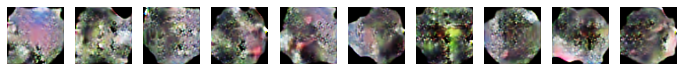

Iter:9550, LossG (fake:52325.5781), LossD:27121.7871 (real:5654.3311, fake:26437.3750), WDistance:-20783.0430, GP:6338.7446
Iter:9600, LossG (fake:-193008.0156), LossD:8941.4199 (real:-179021.1875, fake:-172340.5938), WDistance:-6680.5938, GP:2260.8257
save G >> models/WGAN-GP_G_iter9600.pt, D >> models/WGAN-GP_D_iter9600.pt
Iter:9650, LossG (fake:49601.1719), LossD:9581.8867 (real:26276.9629, fake:33367.9414), WDistance:-7090.9785, GP:2490.9087
Iter:9700, LossG (fake:-51235.7734), LossD:11750.4131 (real:-64097.6328, fake:-56590.5312), WDistance:-7507.1016, GP:4243.3115
Iter:9750, LossG (fake:141950.6719), LossD:10775.0586 (real:131920.6875, fake:138499.2812), WDistance:-6578.5938, GP:4196.4653
Iter:9800, LossG (fake:193955.8750), LossD:18192.4336 (real:180534.6250, fake:192809.5312), WDistance:-12274.9062, GP:5917.5283
save G >> models/WGAN-GP_G_iter9800.pt, D >> models/WGAN-GP_D_iter9800.pt
Iter:9850, LossG (fake:92140.9219), LossD:9870.4268 (real:61272.6914, fake:68573.7969), WDista

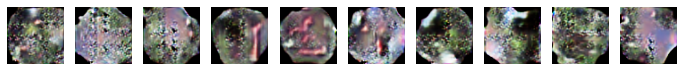

final paramters were saved to G >> models/WGAN-GP_G_final.pt, D >> models/WGAN-GP_D_final.pt
loss was saved to >> result/WGAN-GP_loss.txt


In [53]:
# train
def train():
    # model
    G = Generator().to(cfg.DEVICE)
    D = Discriminator().to(cfg.DEVICE)

    summary(G, (cfg.INPUT_Z_DIM, 1, 1), device=cfg.DEVICE_TYPE)
    summary(D, (cfg.OUTPUT_CHANNEL, cfg.OUTPUT_HEIGHT, cfg.OUTPUT_WIDTH), device=cfg.DEVICE_TYPE)
    
    G.apply(weights_init)
    D.apply(weights_init)

    opt_G = cfg.TRAIN.OPTIMIZER_G(G.parameters(), **cfg.TRAIN.LEARNING_PARAMS_G)
    opt_D = cfg.TRAIN.OPTIMIZER_D(D.parameters(), **cfg.TRAIN.LEARNING_PARAMS_D)

    path_dict = data_load(cfg, hf=cfg.TRAIN.DATA_HORIZONTAL_FLIP, vf=cfg.TRAIN.DATA_VERTICAL_FLIP, rot=cfg.TRAIN.DATA_ROTATION)
    paths = path_dict['paths']
    paths_gt = path_dict['paths_gt']

    # training
    mbi = 0
    train_N = len(paths)
    train_ind = np.arange(train_N)
    np.random.seed(0)
    np.random.shuffle(train_ind)

    list_iter = []
    list_loss_G = []
    list_loss_D = []
    list_loss_D_real = []
    list_loss_D_fake = []
    list_loss_WDistance = []
    list_loss_GP = []

    ones = torch.FloatTensor([1]).to(cfg.DEVICE)
    minus_ones = ones * -1

    print('training start')
    progres_bar = ''
    
    for i in range(cfg.TRAIN.ITERATION):
        if mbi + cfg.TRAIN.MINIBATCH > train_N:
            mb_ind = train_ind[mbi:]
            np.random.shuffle(train_ind)
            mb_ind = np.hstack((mb_ind, train_ind[ : (cfg.TRAIN.MINIBATCH - (train_N - mbi))]))
            mbi = cfg.TRAIN.MINIBATCH - (train_N - mbi)
        else:
            mb_ind = train_ind[mbi : mbi + cfg.TRAIN.MINIBATCH]
            mbi += cfg.TRAIN.MINIBATCH

        # update D
        for _ in range(cfg.TRAIN.WGAN_CRITIC_N):
            opt_D.zero_grad()

            # sample X
            Xs = torch.tensor(get_image(paths[mb_ind], cfg, cfg.INPUT_MODE), dtype=torch.float).to(cfg.DEVICE)

            # sample x
            z = np.random.uniform(-1, 1, size=(cfg.TRAIN.MINIBATCH, cfg.INPUT_Z_DIM, 1, 1))
            z = torch.tensor(z, dtype=torch.float).to(cfg.DEVICE)

            # forward
            Gz = G(z)
            loss_D_fake = D(Gz).mean(0).view(1)
            loss_D_real = D(Xs).mean(0).view(1)
            
            #---
            # Gradient Penalty
            #---
            # sample epsilon from [0, 1]
            epsilon = np.random.random()

            # sample x_hat 
            x_hat = (epsilon * Xs + (1 - epsilon) * Gz).requires_grad_(True)
            
            Dx_hat = D(x_hat)
            musk = torch.ones_like(Dx_hat)
            gradients = torch.autograd.grad(Dx_hat, x_hat, grad_outputs=musk, retain_graph=True, create_graph=True, allow_unused=True)[0]
            gradients = gradients.reshape(-1, 1)
            gradient_penalty = cfg.TRAIN.WGAN_GP_LAMBDA * ((gradients.norm(2, dim=1) - 1) ** 2).mean()
            
            # loss backward
            loss_D_real.backward(ones, retain_graph=True)
            loss_D_fake.backward(minus_ones, retain_graph=True)
            gradient_penalty.backward(retain_graph=True)

            loss_D = loss_D_fake - loss_D_real + gradient_penalty
            Wasserstein_distance = loss_D_real - loss_D_fake

            opt_D.step()
            

        # update G
        opt_G.zero_grad()
        z = np.random.uniform(-1, 1, size=(cfg.TRAIN.MINIBATCH, cfg.INPUT_Z_DIM, 1, 1))
        z = torch.tensor(z, dtype=torch.float).to(cfg.DEVICE)
        loss_G = D(G(z)).mean(0).view(1)
        loss_G.backward(ones)
        opt_G.step()

        progres_bar += '|'
        print('\r' + progres_bar, end='')

        _loss_G = loss_G.item()
        _loss_D = loss_D.item()
        _loss_D_real = loss_D_real.item()
        _loss_D_fake = loss_D_fake.item()
        _Wasserstein_distance = Wasserstein_distance.item()
        _gradient_penalty = gradient_penalty.item()

        if (i + 1) % 10 == 0:
            progres_bar += str(i + 1)
            print('\r' + progres_bar, end='')

            # save process result
            if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
                list_iter.append(i + 1)
                list_loss_G.append(_loss_G)
                list_loss_D.append(_loss_D)
                list_loss_D_real.append(_loss_D_real)
                list_loss_D_fake.append(_loss_D_fake)
                list_loss_WDistance.append(_Wasserstein_distance)
                list_loss_GP.append(_gradient_penalty)
                
        # display training state
        if (i + 1) % cfg.TRAIN.DISPAY_ITERATION_INTERVAL == 0:
            print('\r' + ' ' * len(progres_bar), end='')
            print('\rIter:{}, LossG (fake:{:.4f}), LossD:{:.4f} (real:{:.4f}, fake:{:.4f}), WDistance:{:.4f}, GP:{:.4f}'.format(
                i + 1, _loss_G, _loss_D, _loss_D_real, _loss_D_fake, _Wasserstein_distance, _gradient_penalty))
            progres_bar = ''

        # save parameters
        if (cfg.TRAIN.MODEL_SAVE_INTERVAL != False) and ((i + 1) % cfg.TRAIN.MODEL_SAVE_INTERVAL == 0):
            G_save_path = cfg.TRAIN.MODEL_G_SAVE_PATH.format('iter{}'.format(i + 1))
            D_save_path = cfg.TRAIN.MODEL_D_SAVE_PATH.format('iter{}'.format(i + 1))
            torch.save(G.state_dict(), G_save_path)
            torch.save(D.state_dict(), D_save_path)
            print('save G >> {}, D >> {}'.format(G_save_path, D_save_path))

        # save process result
        if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE and ((i + 1) % cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL == 0):
            result_show(
                G, z, cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH.format('iter' + str(i + 1)), 
                save=cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE, show=True)

    G_save_path = cfg.TRAIN.MODEL_G_SAVE_PATH.format('final')
    D_save_path = cfg.TRAIN.MODEL_D_SAVE_PATH.format('final')
    torch.save(G.state_dict(), G_save_path)
    torch.save(D.state_dict(), D_save_path)
    print('final paramters were saved to G >> {}, D >> {}'.format(G_save_path, D_save_path))

    if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
        f = open(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, 'w')
        df = pd.DataFrame({'iteration' : list_iter, 'loss_G' : list_loss_G, 'loss_D' : list_loss_D, 
                            'loss_D_real' : list_loss_D_real, 'loss_D_fake' : list_loss_D_fake, 'Wasserstein_Distance' : list_loss_WDistance,
                          'GP' : list_loss_GP})
        df.to_csv(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, index=False)
        print('loss was saved to >> {}'.format(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH))

train()

## Test

--------------------
test function
--------------------
result was saved to >> result/WGAN-GP_result_1.jpg


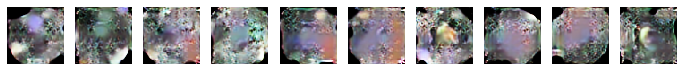

result was saved to >> result/WGAN-GP_result_2.jpg


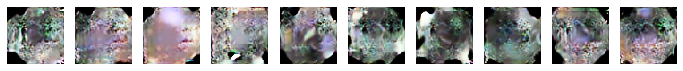

In [0]:
# test
def test():
    print('-' * 20)
    print('test function')
    print('-' * 20)
    G = Generator().to(cfg.DEVICE)
    G.load_state_dict(torch.load(cfg.TEST.MODEL_G_PATH, map_location=torch.device(cfg.DEVICE)))
    G.eval()

    np.random.seed(0)
    
    with torch.no_grad():
        for i in range(cfg.TEST.ITERATION):
            z = np.random.uniform(-1, 1, size=(cfg.TEST.MINIBATCH, cfg.INPUT_Z_DIM))
            z = torch.tensor(z, dtype=torch.float).to(cfg.DEVICE)

            result_show(G, z, cfg.TEST.RESULT_IMAGE_PATH.format(i + 1), save=cfg.TEST.RESULT_SAVE, show=True, cmap=cfg.OUTPUT_CMAP)

test()

In [0]:
def arg_parse():
    parser = argparse.ArgumentParser(description='CNN implemented with Keras')
    parser.add_argument('--train', dest='train', action='store_true')
    parser.add_argument('--test', dest='test', action='store_true')
    args = parser.parse_args()
    return args

# main
if __name__ == '__main__':
    args = arg_parse()

    if args.train:
        train()
    if args.test:
        test()

    if not (args.train or args.test):
        print("please select train or test flag")
        print("train: python main.py --train")
        print("test:  python main.py --test")
        print("both:  python main.py --train --test")
